Trains an autoencoder to perform various tasks based on the run mode.

Reconstruction mode encodes and decodes a single level before displaying the result. 
Recognition mode attempts to classify fixed-size windows of levels by the levels they 
came from based on the windows' encodings. Repair mode trains the autoencoder with 
noisy input before attempting to remove the noise from a given noisy level.

http://www.ccgworkshop.org/2016/Jain.pdf

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tflearn

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Run modes
RECONSTRUCTION = 0
RECOGNITION    = 1
REPAIR         = 2

# Options
run_mode        = 0                                  # What the program does with the autoencoder
grayscale       = False                              # Grayscale v.s. white and black reconstruction image
base_path       = 'VGLC/Super Mario Bros/Processed/' # Path to levels folder
empty_symbol    = '-'                                # Symbol representing an empty tile in the game
window_width    = 4
window_height   = 12
outer_neurons   = 64
inner_neurons   = 16
learning_rate   = 0.005
num_epochs      = 20
batch_size      = 64
validation_size = 0.1                                # Ratio between validation set size to total size
test_level_num  = 0                                  # Which level to reconstruct for RECONSTRUCTION and REPAIR
noise_level     = 0.025                              # Amount of corruption generated for REPAIR and GENERATION modes

In [3]:
def get_windows(level, windows_width, windows_height):
    level_height = len(level)
    level_width = len(level[0])
    if windows_height > level_height or windows_width > level_width:
        print('Error: Window size larger than level size.')
        sys.exit(0)

    windows = []
    for i in range(level_height - windows_height + 1):
        windows.append([])
        for j in range(level_width - windows_width + 1):
            windows[i].append([[symbol for symbol in line[j:j + windows_width]] 
                                       for line in level[i:i + windows_height]])
    return windows # (level_row, level_column, window_row, window_column)

def get_features(symbol):
    return int(symbol != empty_symbol)

In [4]:

window_size = window_width * window_height
levels = []  # (level, row, column)
windows = [] # (level, row, column, flattened_window)

# Data loading and preprocessing
for level_index, file_name in enumerate(os.listdir(base_path)):
    with open(base_path + "/" + file_name, 'r') as file_text:
        lines = file_text.readlines()

        # - Trim newline characters
        for line_index in range(len(lines)):
            if lines[line_index][-1] == '\n':
                lines[line_index] = lines[line_index][:-1]

        # - Generate features
        level = [[get_features(symbol) for symbol in line] for line in lines]
        levels.append(level)

        # - Generate windows
        windows.append([])
        for row_index, row in enumerate(get_windows(level, window_width, window_height)):
            windows[level_index].append([])
            for column_index, window in enumerate(row):
                window_flat = np.array(window).flatten().tolist()
                windows[level_index][row_index].append(window_flat)


In [5]:

# Building the encoder
encoder = tflearn.input_data(shape=[None, window_size])
encoder = tflearn.fully_connected(encoder, outer_neurons)
encoder = tflearn.fully_connected(encoder, inner_neurons)

# Building the decoder
decoder_inner = tflearn.fully_connected(encoder, outer_neurons)
decoder = tflearn.fully_connected(decoder_inner, window_size, activation='leaky_relu')

# Regression with mean square error
net = tflearn.regression(decoder, optimizer='adam', learning_rate=learning_rate, loss='mean_square', metric=None)
model = tflearn.DNN(net, tensorboard_verbose=0)

Training Step: 2299  | total loss: 0.01793 | time: 0.245s
| Adam | epoch: 020 | loss: 0.01793 -- iter: 7296/7333
Training Step: 2300  | total loss: 0.01720 | time: 1.250s
| Adam | epoch: 020 | loss: 0.01720 | val_loss: 0.01242 -- iter: 7333/7333
--


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


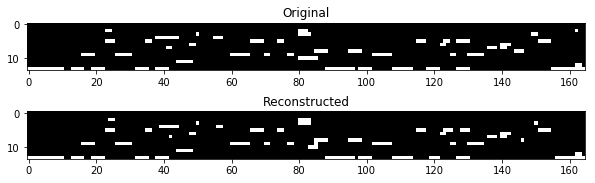

In [6]:
%matplotlib inline
# Do stuff based on run mode
if(run_mode == RECONSTRUCTION):

    # - Split the test level from the training / validation sets
    test_level = levels.pop(test_level_num)
    test_windows = np.reshape(np.array(windows.pop(test_level_num)), (-1, window_size))
    level_height = len(test_level)
    level_width = len(test_level[0])

    # - Training the autoencoder
    temp = []
    for level in windows:
        temp += np.reshape(level, (-1, window_size)).tolist()
    x_train, x_test, _, _ = train_test_split(temp, temp, test_size=validation_size, random_state=1267)
    model.fit(x_train, x_train, n_epoch=num_epochs, validation_set=(x_test, x_test), run_id="auto_encoder", batch_size=batch_size)

    # - Begin dependent reconstruction of the test level
    reconstructed = [[False for _ in range(level_width)] for _ in range(level_height)]
    reconstruction = np.zeros((level_height, level_width), dtype=np.float32)
    windows_predicted = model.predict(test_windows)
    windows_predicted = np.reshape(windows_predicted, (level_height - window_height + 1, 
                                                       level_width - window_width + 1,
                                                       window_height, window_width))
    
    # - Loop through all reconstructed windows
    for row_index, row in enumerate(windows_predicted):
        for column_index, window_flat in enumerate(row):
            # -- Fill in empty tiles in level reconstruction
            # -- Could be done more efficiently
            for i in range(window_height):
                for j in range(window_width):
                    level_row_index = row_index + i
                    level_column_index = column_index + j
                    if not reconstructed[level_row_index][level_column_index]:
                        tile = windows_predicted[row_index][column_index][i][j]
                        tile = tile if grayscale else round(tile)
                        reconstruction[level_row_index][level_column_index] = tile
                        reconstructed[level_row_index][level_column_index] = True

    # - Compare original images with their reconstructions
    f, a = plt.subplots(2, 1, figsize=(10, 3))
    temp = [[ii, ii, ii] for ii in np.array(test_level, dtype=np.float32).flatten()]
    a[0].set_title('Original')
    a[0].imshow(np.reshape(temp, (level_height, level_width, 3)))
    temp = [[ii, ii, ii] for ii in np.array(reconstruction, dtype=np.float32).flatten()]
    a[1].imshow(np.reshape(temp, (level_height, level_width, 3)))
    a[1].set_title('Reconstructed')
    f.show()

elif(run_mode == RECOGNITION):

    # - Splitting the training and validation sets
    x_temp, y_temp = [], []
    for level_index, level in enumerate(windows):
        x_temp += np.reshape(level, (-1, window_size)).tolist()
        y_temp += [level_index] * len(level) * len(level[0])
    x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=validation_size, random_state=1267)

    # - Training the autoencoder
    model.fit(x_train, x_train, n_epoch=num_epochs, validation_set=(x_test, x_test), run_id="auto_encoder", batch_size=batch_size)

    # - Retrieving hidden layer outputs
    encoding_model = tflearn.DNN(encoder, session=model.session)
    x_train = encoding_model.predict(x_train)
    x_test = encoding_model.predict(x_test)

    # Training the random forest classifier
    # -- Not entirely sure if reusing the train / test sets here is allowed
    classifier = RandomForestClassifier(n_estimators=10)
    classifier.fit(x_train, y_train)

    # Testing the random forest classifier
    print("\nClassification report for random forest classifier:\n\n%s"
        % metrics.classification_report(y_test, classifier.predict(x_test)))

elif(run_mode == REPAIR):

    # - Split the test level from the training / validation sets
    test_level = levels.pop(test_level_num)
    windows.pop(test_level_num)
    level_height = len(test_level)
    level_width = len(test_level[0])

    # - Splitting the training and validation sets
    temp = []
    for level in windows:
        temp += np.reshape(level, (-1, window_size)).tolist()
    x_train, x_test, y_train, y_test = train_test_split(temp, temp, test_size=validation_size, random_state=1267)

    # - Applying noise
    for i, window in enumerate(x_train):
        for j, tile in enumerate(window):
            if np.random.rand() < noise_level:
                x_train[i][j] = 1 - tile
    for i, window in enumerate(x_test):
        for j, tile in enumerate(window):
            if np.random.rand() < noise_level:
                x_test[i][j] = 1 - tile
    test_level_noisy = [row[:] for row in test_level]
    for i, row in enumerate(test_level_noisy):
        for j, tile in enumerate(row):
            if np.random.rand() < noise_level:
                test_level_noisy[i][j] = 1 - tile
    test_windows_noisy = get_windows(test_level_noisy, window_width, window_height)
    test_windows_noisy = np.reshape(np.array(test_windows_noisy), (-1, window_size))

    # - Training the autoencoder
    model.fit(x_train, y_train, n_epoch=num_epochs, validation_set=(x_test, y_test), run_id="autoencoder", batch_size=batch_size)

    # - Begin dependent reconstruction of the test level
    reconstructed = [[False for _ in range(level_width)] for _ in range(level_height)]
    reconstruction = np.zeros((level_height, level_width), dtype=np.float32)
    windows_predicted = model.predict(test_windows_noisy)
    windows_predicted = np.reshape(windows_predicted, (level_height - window_height + 1, 
                                                       level_width - window_width + 1,
                                                       window_height, window_width))
    
    # - Loop through all reconstructed windows
    for row_index, row in enumerate(windows_predicted):
        for column_index, window_flat in enumerate(row):
            # -- Fill in empty tiles in level reconstruction
            # -- Could be done more efficiently
            for i in range(window_height):
                for j in range(window_width):
                    level_row_index = row_index + i
                    level_column_index = column_index + j
                    if not reconstructed[level_row_index][level_column_index]:
                        tile = windows_predicted[row_index][column_index][i][j]
                        tile = tile if grayscale else round(tile)
                        reconstruction[level_row_index][level_column_index] = tile
                        reconstructed[level_row_index][level_column_index] = True

    # - Compare original images with their reconstructions
    f, a = plt.subplots(3, 1, figsize=(10, 5))
    temp = [[ii, ii, ii] for ii in np.array(test_level, dtype=np.float32).flatten()]
    a[0].set_title('Original')
    a[0].imshow(np.reshape(temp, (level_height, level_width, 3)))
    temp = [[ii, ii, ii] for ii in np.array(test_level_noisy, dtype=np.float32).flatten()]
    a[1].set_title('Original with Noise')
    a[1].imshow(np.reshape(temp, (level_height, level_width, 3)))
    temp = [[ii, ii, ii] for ii in np.array(reconstruction, dtype=np.float32).flatten()]
    a[2].set_title('Repaired')
    a[2].imshow(np.reshape(temp, (level_height, level_width, 3)))
    f.show()
